Module 1: Dataset Setup and Image Labeling

In [6]:
import os
import pandas as pd
# Path
path = "dataset"
classes = ["clear skin", "dark spots", "puffy eyes", "wrinkles"]
counts = []
for classname in classes:
    folderpath = os.path.join(path, classname)
    image_count = len(os.listdir(folderpath))
    counts.append([classname, image_count])
df = pd.DataFrame(counts, columns=["Class", "Image Count"])
df


,Class,Image Count
0,clear skin,300
1,dark spots,300
2,puffy eyes,300
3,wrinkles,300


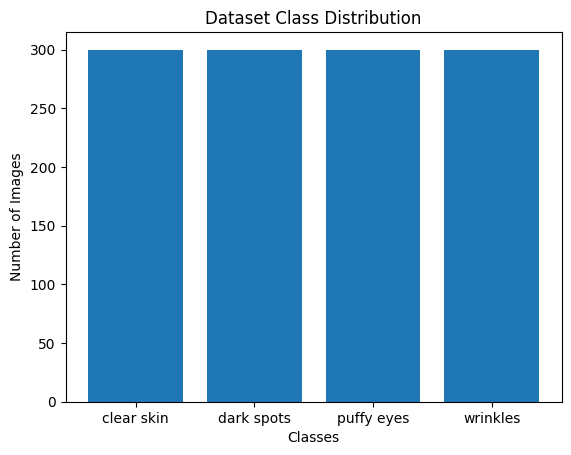

In [7]:
import matplotlib.pyplot as plt
plt.bar(df["Class"], df["Image Count"])
plt.title("Dataset Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

Module 2: Image Preprocessing and Augmentation

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

path = "dataset"
height, width = 224, 224
batchsize = 32

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.6, 1.4),
    channel_shift_range=20.0,
    fill_mode="nearest"
)

datagenerator = datagen.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batchsize,
    class_mode="categorical",
    shuffle=True
)

print("Class indexes:", datagenerator.class_indices)

images_batch, labels_batch = next(datagenerator)
print("Image batch shape:", images_batch.shape)



Found 1200 images belonging to 4 classes.
Class indexes: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}
Image batch shape: (32, 224, 224, 3)


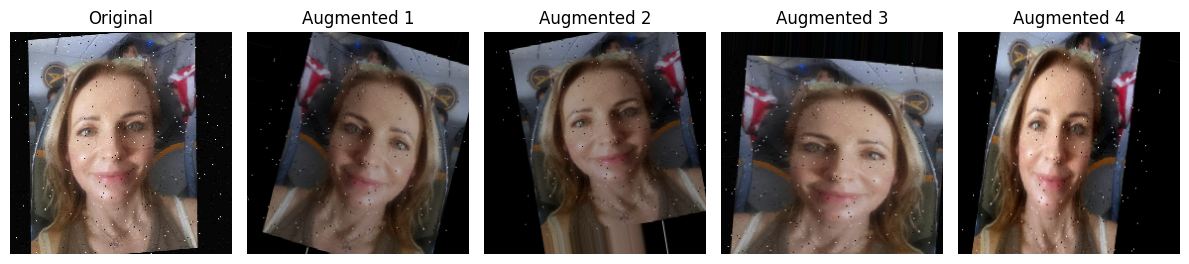

In [9]:

cls = list(datagenerator.class_indices.keys())[0]
img_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])

orig = img_to_array(load_img(img_path, target_size=(height, width)))

augs = [(datagen.random_transform(orig) / 255.0) for _ in range(4)]

orig_disp = orig / 255.0

plt.figure(figsize=(12, 6))
titles = ["Original"] + [f"Augmented {i}" for i in range(1, 5)]
imgs = [orig_disp] + augs

for i, (img, title) in enumerate(zip(imgs, titles), 1):
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


Module 3: Model Training with EfficientNetB0  

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Train (70%) + Temp (30%)
gen1 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

train_gen = gen1.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batchsize,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

temp_gen = gen1.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batchsize,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

#Validation (20%) + Test (10%)
gen2 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=1/3
)

val_gen = gen2.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batchsize,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

test_gen = gen2.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batchsize,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

num_classes = train_gen.num_classes


Found 840 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "model.h5",
        monitor="val_loss",
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]


In [14]:
base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(height, width, 3)
)

base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation="relu")(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(base.input, output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3635 - loss: 1.3021

27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 741ms/step - accuracy: 0.4881 - loss: 1.1914 - val_accuracy: 0.7113 - val_loss: 0.9626 - learning_rate: 1.0000e-04
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7298 - loss: 0.9361

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 645ms/step - accuracy: 0.7440 - loss: 0.8778 - val_accuracy: 0.7937 - val_loss: 0.7525 - learning_rate: 1.0000e-04
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7902 - loss: 0.7479

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 653ms/step - accuracy: 0.7988 - loss: 0.7117 - val_accuracy: 0.8225 - val_loss: 0.6288 - learning_rate: 1.0000e-04
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8106 - loss: 0.6284

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 645ms/step - accuracy: 0.8202 - loss: 0.6132 - val_accuracy: 0.8400 - val_loss: 0.5479 - learning_rate: 1.0000e-04
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8556 - loss: 0.5313

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.8345 - loss: 0.5408 - val_accuracy: 0.8525 - val_loss: 0.4895 - learning_rate: 1.0000e-04
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8576 - loss: 0.4940

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 714ms/step - accuracy: 0.8583 - loss: 0.4902 - val_accuracy: 0.8612 - val_loss: 0.4455 - learning_rate: 1.0000e-04
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8677 - loss: 0.4531

27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 879ms/step - accuracy: 0.8631 - loss: 0.4484 - val_accuracy: 0.8750 - val_loss: 0.4120 - learning_rate: 1.0000e-04
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.8728 - loss: 0.4245

27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 956ms/step - accuracy: 0.8679 - loss: 0.4241 - val_accuracy: 0.8850 - val_loss: 0.3810 - learning_rate: 1.0000e-04
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8724 - loss: 0.3915

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 712ms/step - accuracy: 0.8798 - loss: 0.3895 - val_accuracy: 0.9062 - val_loss: 0.3554 - learning_rate: 1.0000e-04
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8682 - loss: 0.4278

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - accuracy: 0.8940 - loss: 0.3707 - val_accuracy: 0.9150 - val_loss: 0.3324 - learning_rate: 1.0000e-04
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9139 - loss: 0.3451

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 714ms/step - accuracy: 0.9107 - loss: 0.3478 - val_accuracy: 0.9187 - val_loss: 0.3120 - learning_rate: 1.0000e-04
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8995 - loss: 0.3426

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.9143 - loss: 0.3293 - val_accuracy: 0.9275 - val_loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 13/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9153 - loss: 0.3274

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 750ms/step - accuracy: 0.9155 - loss: 0.3089 - val_accuracy: 0.9262 - val_loss: 0.2798 - learning_rate: 1.0000e-04
Epoch 14/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9174 - loss: 0.3046

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 760ms/step - accuracy: 0.9190 - loss: 0.2997 - val_accuracy: 0.9337 - val_loss: 0.2656 - learning_rate: 1.0000e-04
Epoch 15/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9252 - loss: 0.2894

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 739ms/step - accuracy: 0.9143 - loss: 0.2882 - val_accuracy: 0.9438 - val_loss: 0.2543 - learning_rate: 1.0000e-04
Epoch 16/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9299 - loss: 0.2611

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 697ms/step - accuracy: 0.9250 - loss: 0.2714 - val_accuracy: 0.9450 - val_loss: 0.2409 - learning_rate: 1.0000e-04
Epoch 17/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9346 - loss: 0.2528

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 783ms/step - accuracy: 0.9321 - loss: 0.2608 - val_accuracy: 0.9438 - val_loss: 0.2316 - learning_rate: 1.0000e-04
Epoch 18/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9478 - loss: 0.2223

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 745ms/step - accuracy: 0.9310 - loss: 0.2525 - val_accuracy: 0.9525 - val_loss: 0.2209 - learning_rate: 1.0000e-04
Epoch 19/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9289 - loss: 0.2484

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 779ms/step - accuracy: 0.9345 - loss: 0.2396 - val_accuracy: 0.9538 - val_loss: 0.2129 - learning_rate: 1.0000e-04
Epoch 20/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9421 - loss: 0.2382

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 710ms/step - accuracy: 0.9417 - loss: 0.2271 - val_accuracy: 0.9563 - val_loss: 0.2029 - learning_rate: 1.0000e-04
Epoch 21/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9413 - loss: 0.2254

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 691ms/step - accuracy: 0.9440 - loss: 0.2247 - val_accuracy: 0.9575 - val_loss: 0.1945 - learning_rate: 1.0000e-04
Epoch 22/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9557 - loss: 0.2079

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 735ms/step - accuracy: 0.9476 - loss: 0.2190 - val_accuracy: 0.9600 - val_loss: 0.1868 - learning_rate: 1.0000e-04
Epoch 23/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9509 - loss: 0.1976

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 796ms/step - accuracy: 0.9488 - loss: 0.2067 - val_accuracy: 0.9613 - val_loss: 0.1805 - learning_rate: 1.0000e-04
Epoch 24/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9483 - loss: 0.2237

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 685ms/step - accuracy: 0.9524 - loss: 0.2016 - val_accuracy: 0.9625 - val_loss: 0.1735 - learning_rate: 1.0000e-04
Epoch 25/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9511 - loss: 0.1963

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 678ms/step - accuracy: 0.9488 - loss: 0.1995 - val_accuracy: 0.9700 - val_loss: 0.1662 - learning_rate: 1.0000e-04
Epoch 26/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9522 - loss: 0.1877

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 674ms/step - accuracy: 0.9500 - loss: 0.1895 - val_accuracy: 0.9725 - val_loss: 0.1596 - learning_rate: 1.0000e-04
Epoch 27/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9665 - loss: 0.1721

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 696ms/step - accuracy: 0.9631 - loss: 0.1735 - val_accuracy: 0.9663 - val_loss: 0.1553 - learning_rate: 1.0000e-04
Epoch 28/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9555 - loss: 0.1789

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 688ms/step - accuracy: 0.9619 - loss: 0.1804 - val_accuracy: 0.9700 - val_loss: 0.1501 - learning_rate: 1.0000e-04
Epoch 29/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9642 - loss: 0.1688

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 690ms/step - accuracy: 0.9607 - loss: 0.1727 - val_accuracy: 0.9775 - val_loss: 0.1426 - learning_rate: 1.0000e-04
Epoch 30/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9791 - loss: 0.1387

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 686ms/step - accuracy: 0.9667 - loss: 0.1635 - val_accuracy: 0.9762 - val_loss: 0.1373 - learning_rate: 1.0000e-04


In [ ]:
base.trainable = True

for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8127 - loss: 0.6280

27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 836ms/step - accuracy: 0.8048 - loss: 0.6257 - val_accuracy: 0.9762 - val_loss: 0.1314 - learning_rate: 1.0000e-05
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 727ms/step - accuracy: 0.8440 - loss: 0.5493 - val_accuracy: 0.9688 - val_loss: 0.1489 - learning_rate: 1.0000e-05
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 785ms/step - accuracy: 0.8786 - loss: 0.5031 - val_accuracy: 0.9638 - val_loss: 0.1697 - learning_rate: 1.0000e-05
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 771ms/step - accuracy: 0.8738 - loss: 0.4700 - val_accuracy: 0.9613 - val_loss: 0.1872 - learning_rate: 1.0000e-05
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 783ms/step - accuracy: 0.9095 - loss: 0.4262 - val_accuracy: 0.9600 - val_loss: 0.2078 - learning_rate: 3.0000e-06
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 781ms/step - accuracy: 0.9036 - loss: 0.4280 - val_accuracy: 0.9563 - val_loss: 0.2255 - learning_rate: 3.0000e-06


In [16]:
from tensorflow.keras.models import load_model

best_model = load_model("model.h5")

In [ ]:
final_train_acc = history_phase2.history["accuracy"][-1]
final_val_acc = history_phase2.history["val_accuracy"][-1]

test_loss, test_acc = best_model.evaluate(test_gen)

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.8750 - loss: 0.3114
Final Training Accuracy: 90.36%
Final Validation Accuracy: 95.63%
Final Test Accuracy: 87.50%


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.8750 - loss: 0.3114


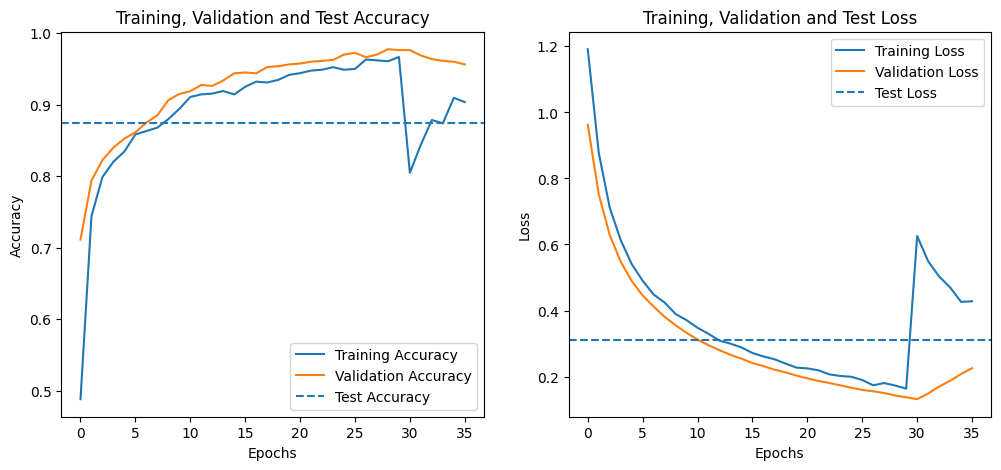

In [ ]:
train_acc = history_phase1.history["accuracy"] + history_phase2.history["accuracy"]
val_acc = history_phase1.history["val_accuracy"] + history_phase2.history["val_accuracy"]

train_loss = history_phase1.history["loss"] + history_phase2.history["loss"]
val_loss = history_phase1.history["val_loss"] + history_phase2.history["val_loss"]


test_loss, test_acc = model.evaluate(test_gen)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.axhline(y=test_acc, linestyle="--", label="Test Accuracy")
plt.title("Training, Validation and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.axhline(y=test_loss, linestyle="--", label="Test Loss")
plt.title("Training, Validation and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


Module 4: Face Detection and Prediction Pipeline 

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
import random

# Load Best Trained Model
model = load_model("model.h5")

# Haar Cascade for Face Detection
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# Labels (from training)
class_labels = list(train_gen.class_indices.keys())  
# Example: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']

# Age Range Mapping
age_range = {
    "clear skin": (18, 25),
    "dark spots": (25, 35),
    "puffy eyes": (30, 45),
    "wrinkles": (40, 60)
}

def generate_age(label):
    low, high = age_range[label]
    return random.randint(low, high)  # single age output



Faces Detected: 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Face 1: dark spots (60.87%) | Age: 31


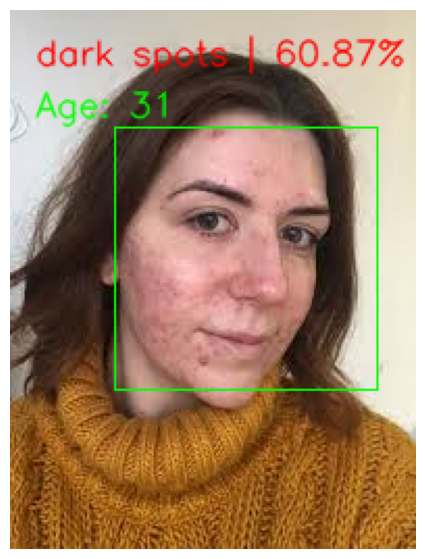

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

# ------------------ Load Image Safely ------------------
img_path = r"C:\Suganth\Project\Infosys Springboard\AI_DermaScan\edee38c6-6337-4d84-92d7-56c25cbc1ad3.jpg"
#   ↑ note the r before string or use "/" instead of "\"

image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
print(f"\nFaces Detected: {len(faces)}\n")

# ------------------ Prediction Loop ------------------
for i, (x, y, w, h) in enumerate(faces, 1):
    face = image[y:y+h, x:x+w]

    # Preprocess
    face_resized = cv2.resize(face, (224, 224))
    face_array = img_to_array(face_resized)
    face_array = np.expand_dims(face_array, axis=0)
    face_array = preprocess_input(face_array)

    # Predict
    preds = model.predict(face_array)
    sorted_idx = preds[0].argsort()[::-1]

    top1 = sorted_idx[0]
    top2 = sorted_idx[1]

    top1_label = class_labels[top1]
    top1_conf = preds[0][top1] * 100

    top2_label = class_labels[top2]
    top2_conf = preds[0][top2] * 100

    # ---------------- Confidence Logic ----------------
    if top1_conf >= 50:
        age = generate_age(top1_label)
        result_text = f"{top1_label} | {top1_conf:.1f}% | Age:{age}"
        print(f"Face {i}: {top1_label} ({top1_conf:.2f}%) | Age: {age}")
    else:
        result_text = f"Uncertain: {top1_label}({top1_conf:.1f}%) or {top2_label}({top2_conf:.1f}%)"
        print(f"Face {i}: Uncertain → {top1_label}({top1_conf:.2f}%) / {top2_label}({top2_conf:.2f}%)")

    # ---------------- Draw Bounding Box (thin) ----------------
    cv2.rectangle(image, (x, y), (x+w, y+h), (0,255,0), 1)

    # ---- Text content ----
    label1 = f"{top1_label}:{top1_conf:.2f}%"
    label2 = f"Age: {age}"

    # ---- Measure text sizes ----
    (text_w1, text_h1), _ = cv2.getTextSize(label1, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 1)
    (text_w2, text_h2), _ = cv2.getTextSize(label2, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 1)
    box_w = max(text_w1, text_w2)

    # ---- Center above box ----
    text_x = x + (w - box_w) // 2
    line1_y = y - 30          # move slightly higher
    line2_y = y - 5           # Age goes separately 15px below 1st line

    # Stay inside frame horizontally
    text_x = max(text_x, 5)
    if text_x + box_w > image.shape[1]-5:
        text_x = image.shape[1] - box_w - 5

    # If too close to top -> move both lines inside box safely
    if line1_y < 15:
        line1_y = y + 15
        line2_y = line1_y + text_h1 + 10

    # ------- Draw thin readable text -------
    cv2.putText(image, label1, (text_x, line1_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,0,255), 1, cv2.LINE_AA)

    cv2.putText(image, label2, (text_x, line2_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,255,0), 1, cv2.LINE_AA)

# ---------------- Show Final Output ----------------
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,7))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()
